## Setup Environment & Import Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from prophet import Prophet
import tqdm as notebook_tqdm

pd.set_option('display.max_columns', None)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
sns.set_theme()

C:\Users\steven.cunden\AppData\Roaming\Python\Python38\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


First, let's import our data. Note that we have a few pre processing steps that are being executed in the `upload_data` function, such as extracting the year, month and day, as well as calculating the trip duration, and the distance between start and stop station

In [3]:
trips, stations = utils.upload_data()

## Profiling

In [4]:
trips.head()

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,customer_plan,year,month,day,date,calc_duration,duration_diff,age,h_distance
0,2319,2016-03-09 13:08:00,2016-03-09 13:47:00,520,W 52 St & 5 Ave,40.759923,-73.976485,363,West Thames St,40.708347,-74.017134,23062,Subscriber,1972.0,male,NaN,2016,3,9,2016-03-09,2340.0,21.0,51.0,4.174902
1,313,2015-07-09 15:42:00,2015-07-09 15:47:00,520,W 52 St & 5 Ave,40.759923,-73.976485,493,W 45 St & 6 Ave,40.756800,-73.982912,16909,Subscriber,1968.0,female,NaN,2015,7,9,2015-07-09,300.0,13.0,55.0,0.401914
2,906,2016-01-11 18:32:00,2016-01-11 18:47:00,520,W 52 St & 5 Ave,40.759923,-73.976485,3162,W 78 St & Broadway,40.783400,-73.980931,15614,Subscriber,1961.0,male,NaN,2016,1,11,2016-01-11,900.0,6.0,62.0,1.648286
3,716,2013-10-30 11:53:00,2013-10-30 12:05:00,520,W 52 St & 5 Ave,40.759923,-73.976485,533,Broadway & W 39 St,40.752996,-73.987216,19280,Subscriber,1954.0,male,NaN,2013,10,30,2013-10-30,720.0,4.0,69.0,0.742178
4,312,2014-06-04 16:12:00,2014-06-04 16:17:00,520,W 52 St & 5 Ave,40.759923,-73.976485,519,E 42 St & Vanderbilt Ave,40.752416,-73.978370,16483,Subscriber,1963.0,male,NaN,2014,6,4,2014-06-04,300.0,12.0,60.0,0.531039


In [5]:
trips.usertype.value_counts()

Subscriber    277448
Customer       38337
Name: usertype, dtype: int64

First, we take a look at the data type to make sure everything aligns with expecatations. Thanks to our `upload_data` function, all of our dates columns have been properly converted

In [6]:
trips.dtypes

tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start_station_id                    int64
start_station_name                 object
start_station_latitude            float64
start_station_longitude           float64
end_station_id                      int64
end_station_name                   object
end_station_latitude              float64
end_station_longitude             float64
bikeid                              int64
usertype                           object
birth_year                        float64
gender                             object
customer_plan                     float64
year                                int64
month                               int64
day                                 int64
date                               object
calc_duration                     float64
duration_diff                     float64
age                               float64
h_distance                        

We can see from the `describe` method, that `tripduration` appears to have some extreme outliers, given how much larger the maximum value is than the 75th percentile. This is certainly cause for investigation. We can also see that one of our records for `age` is unlikely, as the birth year of that individual would mean they were 128 years old at the time of usage. Lastly, we see that the `h_distance column` also has a very high outlier, given how far away its maximum is from its 75tth percentile.

In [7]:
trips.describe()

,tripduration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year,customer_plan,year,month,day,calc_duration,duration_diff,age,h_distance
count,3.157850e+05,315785.000000,315785.000000,315785.000000,315785.000000,315785.000000,315785.000000,315785.000000,276894.000000,0.0,315785.000000,315785.000000,315785.000000,3.157850e+05,315785.000000,276894.000000,315785.000000
mean,9.384988e+02,638.426236,40.735735,-73.989392,631.766471,40.735366,-73.989326,19074.896870,1976.528812,NaN,2014.693956,7.100112,15.832034,9.388082e+02,19.995288,46.471188,1.106254
std,6.534950e+03,772.408824,0.020822,0.014088,762.145089,0.075412,0.132420,2888.180823,11.449689,NaN,1.036277,2.804010,8.669115,6.534471e+03,17.950997,11.449689,9.671095
min,6.000000e+01,72.000000,40.646678,-74.017134,72.000000,0.000000,-74.017134,14529.000000,1885.000000,NaN,2013.000000,1.000000,1.000000,-2.940000e+03,0.000000,23.000000,0.000000
25%,3.910000e+02,312.000000,40.721101,-73.999318,312.000000,40.720874,-73.999744,16687.000000,1969.000000,NaN,2014.000000,5.000000,8.000000,4.200000e+02,8.000000,37.000000,0.537872
50%,6.310000e+02,428.000000,40.736529,-73.990093,427.000000,40.736502,-73.990214,18779.000000,1979.000000,NaN,2015.000000,7.000000,16.000000,6.600000e+02,18.000000,44.000000,0.869205
75%,1.051000e+03,501.000000,40.750977,-73.981281,499.000000,40.750664,-73.981346,21090.000000,1986.000000,NaN,2016.000000,9.000000,23.000000,1.080000e+03,30.000000,54.000000,1.409421
max,1.733173e+06,3425.000000,40.804213,-73.929891,3427.000000,40.804213,0.000000,26884.000000,2000.000000,NaN,2016.000000,12.000000,31.000000,1.733160e+06,3652.000000,138.000000,5416.876458


We also observe that we have a fairly clean dataset, with only two variables having missing values. Those two being `customer_plan` and `birth_year`. We actually don't have any values for `customer_plan` in the data, but have birth year for roughly 88% of our records.

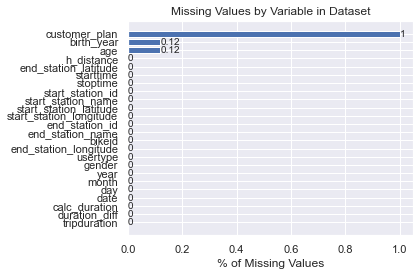

In [8]:
s = round((trips.isna().sum().sort_values()/trips.shape[0]),2)
fig, ax = plt.subplots()
bars = ax.barh(s.index, s.values)
ax.set_xlabel("% of Missing Values")
ax.set_title("Missing Values by Variable in Dataset")
labels = ax.bar_label(ax.containers[0], fontsize=10)
fig.tight_layout()
fig.savefig("images/profiling-nans.png")

However, we do observe that there are some missing values in the variable `gender` that were coded as `unknown`

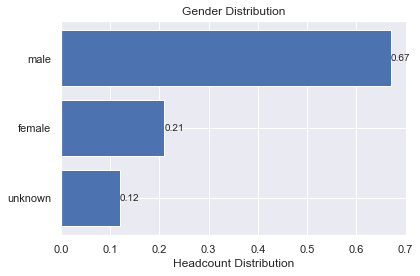

In [9]:
s = round(trips.gender.value_counts(normalize=True).sort_values(),2)
fig, ax = plt.subplots()
bars = ax.barh(s.index, s.values)
ax.set_xlabel("Headcount Distribution")
ax.set_title("Gender Distribution")
labels = ax.bar_label(ax.containers[0], fontsize=10)
fig.tight_layout()

## Age Exploration

Now, as discussed above, we have some extreme outliers for age. The box plot below reveals that we have a lot of customers using bicycles who are older than 80 years old, which does not necessarily make sense

Text(0.5, 1.0, 'Age Violin Plot')

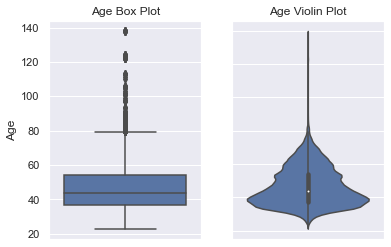

In [10]:
fig, ax = plt.subplots(1,2)

sns.boxplot(data=trips, y="age",ax=ax[0])
ax[0].set_ylabel("Age")
ax[0].set_title("Age Box Plot")

sns.violinplot(data=trips, y="age",ax=ax[1])
ax[1].set_yticklabels([])
ax[1].set_ylabel("")

ax[1].set_title("Age Violin Plot")

As we look at the age distribution across user type, we were very surprised to see that the majority of those discrepancies would occur amongst annual subscribers. Had it not been the case it would have been easily to diagnose those large ages as one-time customers not caring enough to enter the correct information.

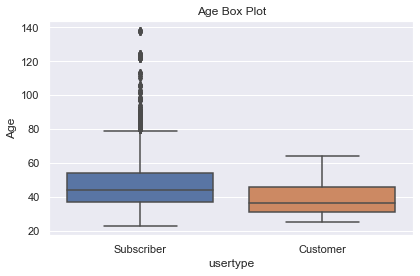

In [11]:
fig, ax = plt.subplots()

sns.boxplot(data=trips, y="age",x='usertype',)
plt.ylabel("Age")
plt.title("Age Box Plot")
fig.tight_layout()
fig.savefig("images/age_box_plot_unfiltered.png")

However, the fact that they are all concentrated in one user type would suggest that there is perphaps some data handling that may have wrongly captured the actual customers age. For that reason, we will decide to remove any record that has an age > 80 years old. This remove roughly 0.29% of our data sample, which is negligible especially considering the tradeoff of having more confidence in our dataset.

In [12]:
trips.loc[trips.age>80].shape[0]/trips.shape[0]

0.002916541317668667

The final age distribution is below:

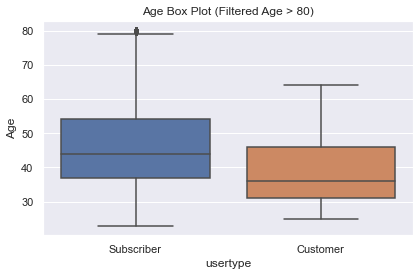

In [13]:
fig, ax = plt.subplots()

trips_2 = trips.loc[trips.age<=80]
sns.boxplot(data=trips_2, y="age",x='usertype', ax=ax)
ax.set_ylabel("Age")
ax.set_title("Age Box Plot (Filtered Age > 80)")
fig.tight_layout()
fig.savefig("images/age_box_plot_filtered.png")


## Distance Exploration

As mentioned earlier, some of our distances appeared to be a really large distance apart. Let's take a quick look at the distribution

<AxesSubplot:>

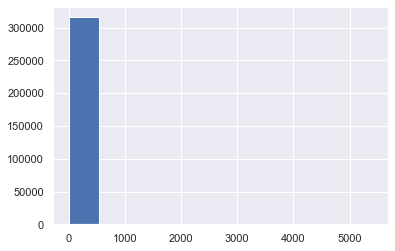

In [15]:
trips.h_distance.hist()

Our histogram is essentially telling us that most of our values are well contained but we have one extreme outlier. Let's take a look

In [16]:
trips.loc[trips.h_distance==trips.h_distance.max()]

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,customer_plan,year,month,day,date,calc_duration,duration_diff,age,h_distance
149687,82,2016-04-04 07:42:00,2016-04-04 07:43:00,3236,W 42 St & Dyer Ave,40.758985,-73.9938,3240,NYCBS Depot BAL - DYR,0.0,0.0,14788,Subscriber,1970.0,male,NaN,2016,4,4,2016-04-04,60.0,22.0,53.0,5416.876458


In the example where we see an extremely large distance, it turns out that the end station named is no longer present in the `stations` and could be why the coordinates were listed as (0,0). So this is a data issue, and we can disregard this datapoint. Let's see if our distribution looks better now

<AxesSubplot:xlabel='h_distance', ylabel='Count'>

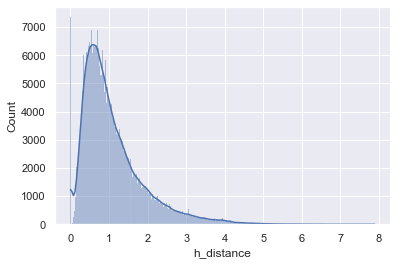

In [17]:
sns.histplot(trips[trips.h_distance < trips.h_distance.max()].h_distance, kde = True)

We see a much better distribution, but it still has two noticeable features. The first one being a concentration of distances being 0. This is explained by the fact that we can only calculate the distances between the start and end stations, and not the trip themselves. So a distance of zero means that the bike has been returned to its same starting point.

The next one is the fact that we see a fairly long tail. Let's make sure our stations are properly geographically located.

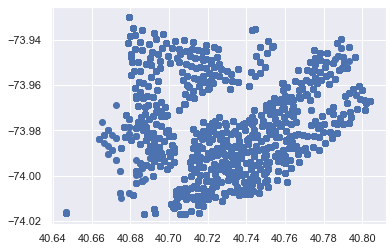

In [18]:
lats = trips.start_station_latitude.tolist()+trips.end_station_latitude.tolist()
longs = trips.start_station_longitude.tolist()+trips.end_station_longitude.tolist()
coords = pd.DataFrame(list(zip(lats, longs)),columns=['latitude','longitude'])
coords = coords.loc[~((coords.latitude==0)&(coords.longitude==0))]

plt.scatter(x=coords.latitude, y=coords.longitude)
plt.show()

It appears now that all of our stations are well within NYC and its buroughs

## Duration Exploration

As we saw in the profiling section, we have some really large outliers for trip duration. We can their manifestations in the box plots below, that are extremely squeezed down. We have also layered on top of it the 24 hour mark, which denotes the usage limit policy that citi bike has.

Any usage that is greater than that is non sensical. So Let's look at whether these are potentially calculation issues

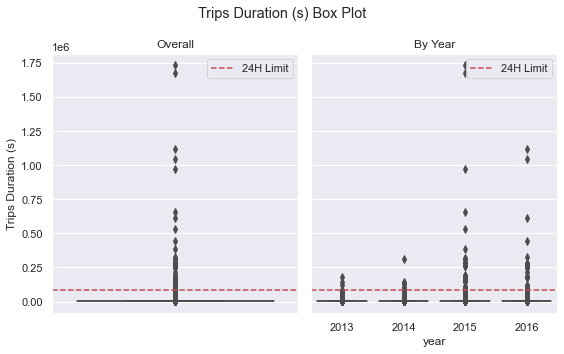

In [19]:
max_duration = 24*60*60
axhs=[[max_duration,"24H Limit", "r"]]

utils.box_plot(df=trips, axhs=axhs, title="Trips Duration (s) Box Plot", savename="box-plot-all")

In our pre processing stage, we manually calculated the trip time using the start and end time. It could be that the outliers above are mis calculations in the data.

However, as we re calculated the trip time for those 72 observations, we see that the mean difference between the reported duration and the calculated duration is roughly 70 seconds, with a maximum of 3700 seconds. These differences are not large enough to account for the large outliers.

So we can conclude that these values are either extreme, uncommon usage, or simply errors in our dataset

In [20]:
trips.loc[trips.tripduration>max_duration].shape

(72, 24)

In [21]:
trips.loc[trips.tripduration>max_duration].duration_diff.mean()

69.76388888888889

In [22]:
trips.loc[trips.tripduration>max_duration].duration_diff.max()

3652.0

Notice that simply removing trips longer than 24 hours does not account for all the outliers. In fact, we still have a lot of outliers left. So, let us consider a percentile removal

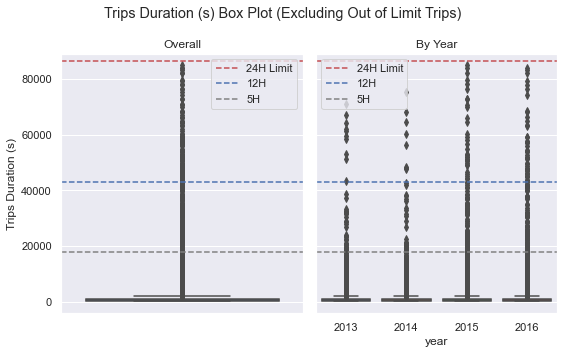

In [23]:
axhs=[[max_duration,"24H Limit", "r"],[12*60*60,"12H", "b"],[5*60*60,"5H", "gray"]]

utils.box_plot(df=trips.loc[trips.tripduration<=max_duration], 
               axhs=axhs, title="Trips Duration (s) Box Plot (Excluding Out of Limit Trips)", 
               savename="box-plot-ool")

We can filter our data by retaining only those trips that are up to the 95th percentile of trip duration. This means that we will get rid of roughly the top 5% of longest trips. Given that our data has over 300,000 rows, we feel comfortable removing these outliers as we believe we now possess a much better sample representation, as shown below

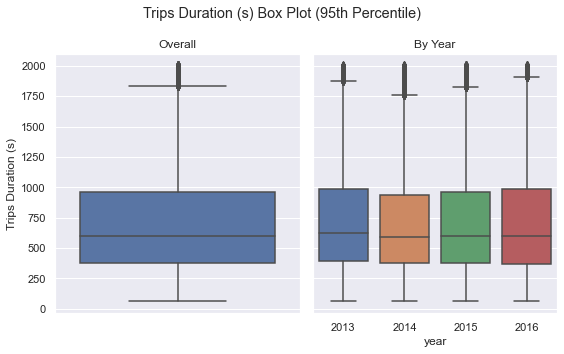

In [24]:
axhs=[]
perc=95
utils.box_plot(df=trips[trips.tripduration < np.percentile(trips.tripduration,perc)], 
               axhs=axhs, title="Trips Duration (s) Box Plot ({}th Percentile)".format(perc), 
               savename="box-plot-{}th".format(perc))

In [25]:
trips_2 = trips[trips.tripduration < np.percentile(trips.tripduration,95)]


## Number of Daily Trips

Let's also take a look at the number of daily trips. At a high level, there does not appear to be extreme outliers like we had seen in the case of trip duration. But let's take a more statisical approach to that analysis

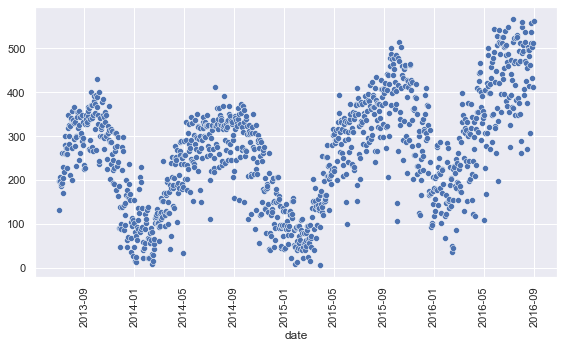

In [40]:
agg = trips_2.groupby(['date']).size()
fig, ax = plt.subplots(figsize=(8,5))
sc = sns.scatterplot(x=agg.index, y=agg.values, ax=ax)
ax.tick_params(axis='x', rotation=90)
fig.tight_layout()
fig.savefig('images/time_series.png')

We will fit an algorithm to the pattern we see above. We will then use the confidence interval for a given point to determine whether that point is an outlier or not. If that point is outside of the range of their 95% confidence interval, then we will classify it as an outlier

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\Users\steven.cunden\Anaconda3\envs\time_series_2\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\steven.cunden\Anaconda3\envs\time_series_2\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\steven.cunden\Anaconda3\envs\time_series_2\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


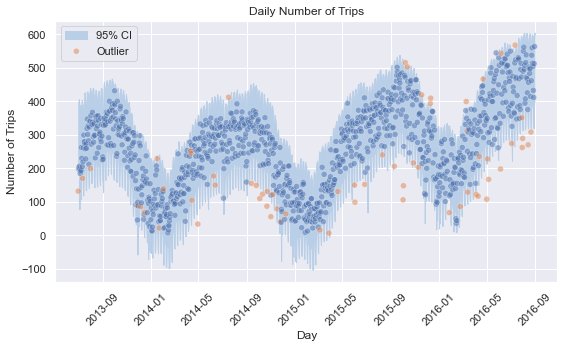

In [27]:
df = agg.reset_index().rename({'date':'ds',0:'y'},axis=1)
m = Prophet(interval_width=0.95)
m.add_country_holidays(country_name='US')
m.fit(df)

future = m.make_future_dataframe(periods=365*2)
forecast = m.predict(future)

df_pred  = pd.concat([forecast,df], axis=1)
df_pred = df_pred.loc[~df_pred.y.isna()]
df_pred = df_pred.loc[:,~df_pred.columns.duplicated()].copy()

df_pred['Upper Outlier'] = np.where(df_pred['y']>df_pred['yhat_upper'],1,0)
df_pred['Lower Outlier'] = np.where(df_pred['y']<df_pred['yhat_lower'],1,0)
df_pred['Outlier'] = df_pred['Upper Outlier'] |df_pred['Lower Outlier'] 

fig, ax = plt.subplots(figsize=(8,5))
ax.fill_between(df_pred.ds, df_pred.yhat_lower, df_pred.yhat_upper, color="#b9cfe7", label='Confidence Interval')
sns.scatterplot(data=df_pred, x='ds',y='y', ax=ax, marker='o', alpha=0.5, hue='Outlier')

ax.set_xlabel("Day")
ax.set_ylabel("Number of Trips")
ax.set_title("Daily Number of Trips")

ax.legend(title='', labels=['95% CI','Outlier'])
ax.tick_params(axis='x', rotation=45)
fig.tight_layout()
fig.savefig("images/daily_trips_outliers.png")

In [28]:
df_pred['Outlier'].sum()/df_pred['Outlier'].shape[0]

0.05637467476149176

We see that our approach outlined roughly 5% of datapoints as outliers - this is expected given our confidence interval. That being said, let's look and see if we see a pattern in those outliers

In [29]:
df_pred['Lower Outlier'].sum()/df_pred['Outlier'].sum()

0.7692307692307693

In [30]:
df_pred.loc[df_pred['Lower Outlier']==1].ds.dt.month.value_counts()

10    7
7     6
11    6
4     6
6     6
8     4
12    3
9     3
3     3
5     3
1     2
2     1
Name: ds, dtype: int64

In [31]:
df_pred.loc[df_pred['Lower Outlier']==1].ds.dt.strftime("%m/%Y").value_counts()

10/2014    4
07/2016    4
11/2014    4
06/2015    3
05/2016    3
04/2016    3
10/2015    3
03/2015    2
07/2013    2
09/2014    2
04/2014    2
12/2013    2
08/2016    2
06/2014    2
08/2013    1
08/2015    1
09/2015    1
04/2015    1
12/2014    1
01/2016    1
02/2016    1
03/2016    1
01/2014    1
06/2016    1
11/2013    1
11/2015    1
Name: ds, dtype: int64

However, after some additional investigation, we did not find concrete evidence that these outliers had a pattern with their time period. It is highly likely that those are simply stastitical noise.